In [2]:
import config as cf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import imageio

from sklearn.cluster import DBSCAN
from esda.moran import Moran
from libpysal.weights import lat2W
from scipy.spatial.distance import cdist


from pathlib import Path 

In [3]:
'''
Config params
'''

ADD_ANT_EVERY = 50
INIT_X = 20
INIT_Y = 30

NEST_FACTOR = 0.95

GRID = [40, 40]
GRID_SIZE = np.prod(GRID)

FOCAL_AREA = [3, 3]
# FOCAL_AREA = [5, 5]
FOCAL_SIZE = np.prod(FOCAL_AREA)
ACTION_MAP = [(-1, -1), (0, -1), (1, -1), (-1, 0), (0, 0), (1, 0), (-1, 1), (0, 1), (1, 1)]
OPPOSITE_ACTIONS = list(reversed(range(len(ACTION_MAP))))

FOOD_LOCATION = [30, 5]
FOOD_SIZE = [10, 10]

# WALL_LEFT = 15
# WALL_RIGHT = 25
# WALL_TOP = 10

WALL_LEFT = 0
WALL_RIGHT = 40
# WALL_TOP = 10
WALL_TOP = 0

NUM_PHEROMONE_LEVELS = 10
# DECAY_FACTOR = 0.01
# DECAY_FACTOR = 0.005
# DECAY_FACTOR = 1.0

NUM_OBSERVATIONS = NUM_PHEROMONE_LEVELS
NUM_STATES = FOCAL_SIZE
NUM_ACTIONS = FOCAL_SIZE

MAX_LEN = 500

In [4]:
class Ant(object):
    def __init__(self, mdp, init_x, init_y):
        self.mdp = mdp
        self.x_pos = init_x
        self.y_pos = init_y
        self.traj = [(init_x, init_y)]
        self.distance = []
        self.backward_step = 0
        self.is_returning = False
        self.timer = 0
        # self.time_since_last_round_trip = 0
        self.number_of_round_trips = 0

    def update_forward(self, x_pos, y_pos):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.traj.append((x_pos, y_pos))
        self.distance.append(dis(x_pos, y_pos, cf.INIT_X, cf.INIT_Y))

    def update_backward(self, x_pos, y_pos):
        self.x_pos = x_pos
        self.y_pos = y_pos
        self.distance.append(dis(x_pos, y_pos, cf.INIT_X, cf.INIT_Y))

In [5]:
class Env(object):
    def __init__(self, decay_factor):
        self.visit_matrix = np.zeros((cf.GRID[0], cf.GRID[1]))
        self.obs_matrix = np.zeros((cf.NUM_OBSERVATIONS, cf.GRID[0], cf.GRID[1]))
        # self.obs_matrix[0, :, :] = 1.0
        self.obs_matrix[0, :, :] = 0.0
        self.decay_factor = decay_factor

    def get_A(self, ant):
        A = np.zeros((cf.NUM_OBSERVATIONS, cf.NUM_STATES))
        for s in range(cf.NUM_STATES):
            delta = cf.ACTION_MAP[s]
            A[:, s] = self.obs_matrix[:, ant.x_pos + delta[0], ant.y_pos + delta[1]]
        return A

    def get_obs(self, ant):
        obs_vec = self.obs_matrix[:, ant.x_pos, ant.y_pos]
        return np.argmax(obs_vec)

    def check_food(self, x_pos, y_pos):
        is_food = False
        if (x_pos > (cf.FOOD_LOCATION[0] - cf.FOOD_SIZE[0])) and (
            x_pos < (cf.FOOD_LOCATION[0] + cf.FOOD_SIZE[0])
        ):
            if (y_pos > (cf.FOOD_LOCATION[1] - cf.FOOD_SIZE[1])) and (
                y_pos < (cf.FOOD_LOCATION[1] + cf.FOOD_SIZE[1])
            ):
                is_food = True
        return is_food

    def check_walls(self, orig_x, orig_y, x_pos, y_pos):
        valid = True
        if orig_y > cf.WALL_TOP:
            if orig_x >= cf.WALL_LEFT and x_pos <= cf.WALL_LEFT:
                valid = False
            if orig_x <= cf.WALL_RIGHT and x_pos >= cf.WALL_RIGHT:
                valid = False
        if orig_y <= cf.WALL_TOP:
            if y_pos > cf.WALL_TOP and ((x_pos < cf.WALL_LEFT) or (x_pos > cf.WALL_RIGHT)):
                valid = False
        return valid

    def step_forward(self, ant, action):
        delta = cf.ACTION_MAP[action]
        x_pos = np.clip(ant.x_pos + delta[0], 1, cf.GRID[0] - 2)
        y_pos = np.clip(ant.y_pos + delta[1], 1, cf.GRID[1] - 2)

        if self.check_food(x_pos, y_pos) and np.random.rand() < cf.NEST_FACTOR:
            ant.is_returning = True
            ant.backward_step = 0

        if self.check_walls(ant.x_pos, ant.y_pos, x_pos, y_pos):
            ant.update_forward(x_pos, y_pos)

    def step_backward(self, ant):
        path_len = len(ant.traj)
        next_step = path_len - (ant.backward_step + 1)
        pos = ant.traj[next_step]
        ant.update_backward(pos[0], pos[1])

        self.visit_matrix[pos[0], pos[1]] += 1
        curr_obs = np.argmax(self.obs_matrix[:, pos[0], pos[1]])
        curr_obs = min(curr_obs + 1, cf.NUM_OBSERVATIONS - 1)

        self.obs_matrix[:, pos[0], pos[1]] = 0.0
        self.obs_matrix[curr_obs, pos[0], pos[1]] = 1.0

        ant.backward_step += 1
        if ant.backward_step >= path_len - 1:
            ant.is_returning = False
            traj = ant.traj
            ant.traj = []
            return True, traj
        else:
            return False, None

    def decay(self):
        for x in range(cf.GRID[0]):
            for y in range(cf.GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                # if (curr_obs > 0) and (np.random.rand() < cf.DECAY_FACTOR):
                if (curr_obs > 0) and (np.random.rand() < self.decay_factor):
                    curr_obs = curr_obs - 1
                    self.obs_matrix[:, x, y] = 0.0
                    self.obs_matrix[curr_obs, x, y] = 1.0

    # def get_pheromone_values(self):
    #     pheromone_values = []
    #     for x in range(cf.GRID[0]):
    #         for y in range(cf.GRID[1]):
    #             curr_obs = np.argmax(self.obs_matrix[:, x, y])
    #             pheromone_values.append(curr_obs)
    #     return np.array(pheromone_values)

    def get_nonzero_pheromone_locations(self):
        pheromone_locations = []
        for x in range(cf.GRID[0]):
            for y in range(cf.GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                # if self.obs_matrix[:, x, y] > 0.0:
                if curr_obs > 0.0:
                    # print(curr_obs)
                    pheromone_locations.append((x, y))
        return np.array(pheromone_locations)

    def get_values(self, ants):
        ant_locations = []
        pheromone_values = []
        for ant in ants:
            ant_locations.append((ant.x_pos, ant.y_pos))
            pheromone_values.append(np.argmax(self.obs_matrix[:, ant.x_pos, ant.y_pos]))
        return np.array(ant_locations), np.array(pheromone_values)
        
    def run_dbscan_on_pheromone_locs(self, eps, min_samples):
        pheromone_locations = self.get_nonzero_pheromone_locations()
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(pheromone_locations)
        return labels

    def run_dbscan_on_ant_locs(self, eps, min_samples, ants):
        ant_locations, _ = self.get_values(ants)
        dbscan = DBSCAN(eps = eps, min_samples = min_samples)
        labels = dbscan.fit_predict(ant_locations)
        return labels

    def plot(self, ants, savefig=False, name="", ant_only_gif=False):
        x_pos_forward, y_pos_forward = [], []
        x_pos_backward, y_pos_backward = [], []
        for ant in ants:
            if ant.is_returning:
                x_pos_backward.append(ant.x_pos)
                y_pos_backward.append(ant.y_pos)
            else:
                x_pos_forward.append(ant.x_pos)
                y_pos_forward.append(ant.y_pos)

        img = np.ones((cf.GRID[0], cf.GRID[1]))
        fig, ax = plt.subplots()
        ax.imshow(img.T, cmap="gray")
        plot_matrix = np.zeros((cf.GRID[0], cf.GRID[1]))

        for x in range(cf.GRID[0]):
            for y in range(cf.GRID[1]):
                curr_obs = np.argmax(self.obs_matrix[:, x, y])
                plot_matrix[x, y] = curr_obs

        if ant_only_gif == False:
            ax.imshow(plot_matrix.T, alpha=0.7, vmin=0)

        # Overlay the green rectangle for FOOD_LOCATION
        food_x, food_y = cf.FOOD_LOCATION
        food_width, food_height = cf.FOOD_SIZE
        ax.add_patch(plt.Rectangle((food_x, food_y), food_width, food_height, color="green", alpha=0.5))

        if not savefig:
            ax.scatter(x_pos_forward, y_pos_forward, color="red", s=5)
            ax.scatter(x_pos_backward, y_pos_backward, color="blue", s=5)

        if not savefig:
            fig.canvas.draw()
            img = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
            img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close("all")
            return img
        else:
            plt.savefig(name)
        plt.close("all")

In [6]:
class MDP(object):
    def __init__(self, A, B, C):
        self.A = A
        self.B = B
        self.C = C
        self.p0 = np.exp(-16)

        self.num_states = self.A.shape[1]
        self.num_obs = self.A.shape[0]
        self.num_actions = self.B.shape[0]

        self.A = self.A + self.p0
        self.A = self.normdist(self.A)
        self.lnA = np.log(self.A)

        self.B = self.B + self.p0
        for a in range(self.num_actions):
            self.B[a] = self.normdist(self.B[a])

        self.C = self.C + self.p0
        self.C = self.normdist(self.C)

        self.sQ = np.zeros([self.num_states, 1])
        self.uQ = np.zeros([self.num_actions, 1])
        self.prev_action = None
        self.t = 0

    def set_A(self, A):
        self.A = A + self.p0
        self.A = self.normdist(self.A)
        self.lnA = np.log(self.A)

    def reset(self, obs):
        self.t = 0
        self.curr_obs = obs
        likelihood = self.lnA[obs, :]
        likelihood = likelihood[:, np.newaxis]
        self.sQ = self.softmax(likelihood)
        self.prev_action = self.random_action()

    def step(self, obs):
        """ state inference """
        likelihood = self.lnA[obs, :]
        likelihood = likelihood[:, np.newaxis]
        prior = np.dot(self.B[self.prev_action], self.sQ)
        prior = np.log(prior)
        self.sQ = self.softmax(prior)

        """ action inference """
        SCALE = 10
        neg_efe = np.zeros([self.num_actions, 1])
        for a in range(self.num_actions):
            fs = np.dot(self.B[a], self.sQ)
            fo = np.dot(self.A, fs)
            fo = self.normdist(fo + self.p0)
            utility = np.sum(fo * np.log(fo / self.C), axis=0)
            utility = utility[0]
            neg_efe[a] -= utility / SCALE

        # priors
        neg_efe[4] -= 20.0
        neg_efe[cf.OPPOSITE_ACTIONS[self.prev_action]] -= 20.0  # type: ignore

        # action selection
        self.uQ = self.softmax(neg_efe)
        action = np.argmax(np.random.multinomial(1, self.uQ.squeeze()))
        self.prev_action = action
        return action

    def random_action(self):
        return int(np.random.choice(range(self.num_actions)))

    @staticmethod
    def softmax(x):
        x = x - x.max()
        x = np.exp(x)
        x = x / np.sum(x)
        return x

    @staticmethod
    def normdist(x):
        return np.dot(x, np.diag(1 / np.sum(x, 0)))

In [7]:
def create_ant(init_x, init_y, C):
    A = np.zeros((cf.NUM_OBSERVATIONS, cf.NUM_STATES))
    B = np.zeros((cf.NUM_ACTIONS, cf.NUM_STATES, cf.NUM_STATES))
    for a in range(cf.NUM_ACTIONS):
        B[a, a, :] = 1.0
    mdp = MDP(A, B, C)
    ant = Ant(mdp, init_x, init_y)
    return ant


def dis(x1, y1, x2, y2):
    return np.sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))


def plot_path(path, save_name):
    path = np.array(path)
    _, ax = plt.subplots(1, 1)
    ax.set_xlim(cf.GRID[0])
    ax.set_ylim(cf.GRID[1])
    ax.plot(path[:, 0], path[:, 1], "-o", color="red", alpha=0.4)
    plt.savefig(save_name)
    plt.close("all")


def save_gif(imgs, path, fps=32):
    imageio.mimsave(path, imgs, fps=fps)

In [8]:
def main(num_steps, decay_factor, init_ants, max_ants, C, ctr, num_runs, save=True, switch=False, name="", ant_only_gif=False):
    env = Env(decay_factor)
    ants = []
    paths = []
    for _ in range(init_ants):
        ant = create_ant(cf.INIT_X, cf.INIT_Y, C)
        obs = env.get_obs(ant)
        A = env.get_A(ant)
        ant.mdp.set_A(A)
        ant.mdp.reset(obs)
        ants.append(ant)

    imgs = []
    completed_trips = 0

    Morans_i_values = []

    distance = 0
    distances = []

    cluster_density = 0
    cluster_densities = []
    num_clusters = []

    ant_locations = []
    num_round_trips_per_time = []

    num_rt_at_time_t = 0

    for t in range(num_steps):
        t_dis = 0

        for ant in ants:
            for ant_2 in ants:
                t_dis += dis(ant.x_pos, ant.y_pos, ant_2.x_pos, ant_2.y_pos)

        current_avg_dist = t_dis / len(ants)
        distance += current_avg_dist
        distances.append(current_avg_dist)

        ant_positions, pheromone_values = env.get_values(ants)

        # Combine ant locations and pheromone values
        Z = np.column_stack((ant_positions, pheromone_values))

        # Create weight matrix
        w = lat2W(Z.shape[0], Z.shape[1])

        # Create PySAL Moran obj
        m_i = Moran(Z, w)

        # add to the Moran's I list
        Morans_i_values.append(m_i.I)

        if len(paths) == 0:
            cluster_densities.append(0)
            num_clusters.append(0)
        else:

            # ant_trajectory_locations = [point for trajectory in paths for point in trajectory]


            # Create and fit a DBSCAN model
            eps = 5
            # min_samples = len(ants) // 5
            min_samples = 3
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(ant_positions)

            # the number of DBSCAN Clusters
            n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

            # Calculate cluster sizes
            cluster_sizes = [len(ant_positions[dbscan_labels == label]) for label in set(dbscan_labels)]

            # Calculate the average density
            if cluster_sizes:
                average_density = len(ant_positions) / len(cluster_sizes)
            else:
                average_density = 0

            # print("Average Density of Clusters:", average_density)

            cluster_densities.append(average_density)
            num_clusters.append(n_clusters)


        # if t % (num_steps // 100) == 0:
        print(f"Step {t + 1}/{num_steps} of Simulation {ctr + 1}/{num_runs}")

        if t % cf.ADD_ANT_EVERY == 0 and len(ants) < max_ants:
            ant = create_ant(cf.INIT_X, cf.INIT_Y, C)
            obs = env.get_obs(ant)
            A = env.get_A(ant)
            ant.mdp.set_A(A)
            ant.mdp.reset(obs)
            ants.append(ant)

        # if switch and t % (num_steps // 2) == 0:
        #     cf.FOOD_LOCATION[0] = cf.GRID[0] - cf.FOOD_LOCATION[0]

        for ant in ants:
            if not ant.is_returning:
                obs = env.get_obs(ant)
                A = env.get_A(ant)
                ant.mdp.set_A(A)
                action = ant.mdp.step(obs)
                env.step_forward(ant, action)
            else:
                is_complete, traj = env.step_backward(ant)
                completed_trips += int(is_complete)

                if is_complete:
                    paths.append(traj)

                    # increment the number of round trips by 1
                    ant.number_of_round_trips += 1
                    num_rt_at_time_t += 1

        num_round_trips_per_time.append(num_rt_at_time_t)
    
        if save:
            if t in np.arange(0, num_steps, num_steps // 30):
            # if t in np.arange(0, num_steps):
                env.plot(ants, savefig=True, name=f"my_imgs_full_sim/{name}_{t}.png")
            else:
                img = env.plot(ants, ant_only_gif=ant_only_gif)
                imgs.append(img)

        # round_trips_over_time.append(completed_trips / max_ants)
        ant_locations.append([[ant.x_pos, ant.y_pos] for ant in ants])

    if save:
        save_gif(imgs, f"my_imgs_full_sim/{name}.gif")


    ant_locations = np.array(ant_locations)

    np.save(f"my_imgs_full_sim/{name}_locations", ant_locations)


    return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values

Step 1/1000 of Simulation 1/5
Step 2/1000 of Simulation 1/5
Step 3/1000 of Simulation 1/5
Step 4/1000 of Simulation 1/5
Step 5/1000 of Simulation 1/5
Step 6/1000 of Simulation 1/5
Step 7/1000 of Simulation 1/5
Step 8/1000 of Simulation 1/5
Step 9/1000 of Simulation 1/5
Step 10/1000 of Simulation 1/5
Step 11/1000 of Simulation 1/5
Step 12/1000 of Simulation 1/5
Step 13/1000 of Simulation 1/5
Step 14/1000 of Simulation 1/5
Step 15/1000 of Simulation 1/5
Step 16/1000 of Simulation 1/5
Step 17/1000 of Simulation 1/5
Step 18/1000 of Simulation 1/5
Step 19/1000 of Simulation 1/5
Step 20/1000 of Simulation 1/5
Step 21/1000 of Simulation 1/5
Step 22/1000 of Simulation 1/5
Step 23/1000 of Simulation 1/5
Step 24/1000 of Simulation 1/5
Step 25/1000 of Simulation 1/5
Step 26/1000 of Simulation 1/5
Step 27/1000 of Simulation 1/5
Step 28/1000 of Simulation 1/5
Step 29/1000 of Simulation 1/5
Step 30/1000 of Simulation 1/5
Step 31/1000 of Simulation 1/5
Step 32/1000 of Simulation 1/5
Step 33/1000 of S

Step 261/1000 of Simulation 1/5
Step 262/1000 of Simulation 1/5
Step 263/1000 of Simulation 1/5
Step 264/1000 of Simulation 1/5
Step 265/1000 of Simulation 1/5
Step 266/1000 of Simulation 1/5
Step 267/1000 of Simulation 1/5
Step 268/1000 of Simulation 1/5
Step 269/1000 of Simulation 1/5
Step 270/1000 of Simulation 1/5
Step 271/1000 of Simulation 1/5
Step 272/1000 of Simulation 1/5
Step 273/1000 of Simulation 1/5
Step 274/1000 of Simulation 1/5
Step 275/1000 of Simulation 1/5
Step 276/1000 of Simulation 1/5
Step 277/1000 of Simulation 1/5
Step 278/1000 of Simulation 1/5
Step 279/1000 of Simulation 1/5
Step 280/1000 of Simulation 1/5
Step 281/1000 of Simulation 1/5
Step 282/1000 of Simulation 1/5
Step 283/1000 of Simulation 1/5
Step 284/1000 of Simulation 1/5
Step 285/1000 of Simulation 1/5
Step 286/1000 of Simulation 1/5
Step 287/1000 of Simulation 1/5
Step 288/1000 of Simulation 1/5
Step 289/1000 of Simulation 1/5
Step 290/1000 of Simulation 1/5
Step 291/1000 of Simulation 1/5
Step 292

Step 518/1000 of Simulation 1/5
Step 519/1000 of Simulation 1/5
Step 520/1000 of Simulation 1/5
Step 521/1000 of Simulation 1/5
Step 522/1000 of Simulation 1/5
Step 523/1000 of Simulation 1/5
Step 524/1000 of Simulation 1/5
Step 525/1000 of Simulation 1/5
Step 526/1000 of Simulation 1/5
Step 527/1000 of Simulation 1/5
Step 528/1000 of Simulation 1/5
Step 529/1000 of Simulation 1/5
Step 530/1000 of Simulation 1/5
Step 531/1000 of Simulation 1/5
Step 532/1000 of Simulation 1/5
Step 533/1000 of Simulation 1/5
Step 534/1000 of Simulation 1/5
Step 535/1000 of Simulation 1/5
Step 536/1000 of Simulation 1/5
Step 537/1000 of Simulation 1/5
Step 538/1000 of Simulation 1/5
Step 539/1000 of Simulation 1/5
Step 540/1000 of Simulation 1/5
Step 541/1000 of Simulation 1/5
Step 542/1000 of Simulation 1/5
Step 543/1000 of Simulation 1/5
Step 544/1000 of Simulation 1/5
Step 545/1000 of Simulation 1/5
Step 546/1000 of Simulation 1/5
Step 547/1000 of Simulation 1/5
Step 548/1000 of Simulation 1/5
Step 549

Step 775/1000 of Simulation 1/5
Step 776/1000 of Simulation 1/5
Step 777/1000 of Simulation 1/5
Step 778/1000 of Simulation 1/5
Step 779/1000 of Simulation 1/5
Step 780/1000 of Simulation 1/5
Step 781/1000 of Simulation 1/5
Step 782/1000 of Simulation 1/5
Step 783/1000 of Simulation 1/5
Step 784/1000 of Simulation 1/5
Step 785/1000 of Simulation 1/5
Step 786/1000 of Simulation 1/5
Step 787/1000 of Simulation 1/5
Step 788/1000 of Simulation 1/5
Step 789/1000 of Simulation 1/5
Step 790/1000 of Simulation 1/5
Step 791/1000 of Simulation 1/5
Step 792/1000 of Simulation 1/5
Step 793/1000 of Simulation 1/5
Step 794/1000 of Simulation 1/5
Step 795/1000 of Simulation 1/5
Step 796/1000 of Simulation 1/5
Step 797/1000 of Simulation 1/5
Step 798/1000 of Simulation 1/5
Step 799/1000 of Simulation 1/5
Step 800/1000 of Simulation 1/5
Step 801/1000 of Simulation 1/5
Step 802/1000 of Simulation 1/5
Step 803/1000 of Simulation 1/5
Step 804/1000 of Simulation 1/5
Step 805/1000 of Simulation 1/5
Step 806

Step 34/1000 of Simulation 2/5
Step 35/1000 of Simulation 2/5
Step 36/1000 of Simulation 2/5
Step 37/1000 of Simulation 2/5
Step 38/1000 of Simulation 2/5
Step 39/1000 of Simulation 2/5
Step 40/1000 of Simulation 2/5
Step 41/1000 of Simulation 2/5
Step 42/1000 of Simulation 2/5
Step 43/1000 of Simulation 2/5
Step 44/1000 of Simulation 2/5
Step 45/1000 of Simulation 2/5
Step 46/1000 of Simulation 2/5
Step 47/1000 of Simulation 2/5
Step 48/1000 of Simulation 2/5
Step 49/1000 of Simulation 2/5
Step 50/1000 of Simulation 2/5
Step 51/1000 of Simulation 2/5
Step 52/1000 of Simulation 2/5
Step 53/1000 of Simulation 2/5
Step 54/1000 of Simulation 2/5
Step 55/1000 of Simulation 2/5
Step 56/1000 of Simulation 2/5
Step 57/1000 of Simulation 2/5
Step 58/1000 of Simulation 2/5
Step 59/1000 of Simulation 2/5
Step 60/1000 of Simulation 2/5
Step 61/1000 of Simulation 2/5
Step 62/1000 of Simulation 2/5
Step 63/1000 of Simulation 2/5
Step 64/1000 of Simulation 2/5
Step 65/1000 of Simulation 2/5
Step 66/

Step 294/1000 of Simulation 2/5
Step 295/1000 of Simulation 2/5
Step 296/1000 of Simulation 2/5
Step 297/1000 of Simulation 2/5
Step 298/1000 of Simulation 2/5
Step 299/1000 of Simulation 2/5
Step 300/1000 of Simulation 2/5
Step 301/1000 of Simulation 2/5
Step 302/1000 of Simulation 2/5
Step 303/1000 of Simulation 2/5
Step 304/1000 of Simulation 2/5
Step 305/1000 of Simulation 2/5
Step 306/1000 of Simulation 2/5
Step 307/1000 of Simulation 2/5
Step 308/1000 of Simulation 2/5
Step 309/1000 of Simulation 2/5
Step 310/1000 of Simulation 2/5
Step 311/1000 of Simulation 2/5
Step 312/1000 of Simulation 2/5
Step 313/1000 of Simulation 2/5
Step 314/1000 of Simulation 2/5
Step 315/1000 of Simulation 2/5
Step 316/1000 of Simulation 2/5
Step 317/1000 of Simulation 2/5
Step 318/1000 of Simulation 2/5
Step 319/1000 of Simulation 2/5
Step 320/1000 of Simulation 2/5
Step 321/1000 of Simulation 2/5
Step 322/1000 of Simulation 2/5
Step 323/1000 of Simulation 2/5
Step 324/1000 of Simulation 2/5
Step 325

Step 551/1000 of Simulation 2/5
Step 552/1000 of Simulation 2/5
Step 553/1000 of Simulation 2/5
Step 554/1000 of Simulation 2/5
Step 555/1000 of Simulation 2/5
Step 556/1000 of Simulation 2/5
Step 557/1000 of Simulation 2/5
Step 558/1000 of Simulation 2/5
Step 559/1000 of Simulation 2/5
Step 560/1000 of Simulation 2/5
Step 561/1000 of Simulation 2/5
Step 562/1000 of Simulation 2/5
Step 563/1000 of Simulation 2/5
Step 564/1000 of Simulation 2/5
Step 565/1000 of Simulation 2/5
Step 566/1000 of Simulation 2/5
Step 567/1000 of Simulation 2/5
Step 568/1000 of Simulation 2/5
Step 569/1000 of Simulation 2/5
Step 570/1000 of Simulation 2/5
Step 571/1000 of Simulation 2/5
Step 572/1000 of Simulation 2/5
Step 573/1000 of Simulation 2/5
Step 574/1000 of Simulation 2/5
Step 575/1000 of Simulation 2/5
Step 576/1000 of Simulation 2/5
Step 577/1000 of Simulation 2/5
Step 578/1000 of Simulation 2/5
Step 579/1000 of Simulation 2/5
Step 580/1000 of Simulation 2/5
Step 581/1000 of Simulation 2/5
Step 582

Step 809/1000 of Simulation 2/5
Step 810/1000 of Simulation 2/5
Step 811/1000 of Simulation 2/5
Step 812/1000 of Simulation 2/5
Step 813/1000 of Simulation 2/5
Step 814/1000 of Simulation 2/5
Step 815/1000 of Simulation 2/5
Step 816/1000 of Simulation 2/5
Step 817/1000 of Simulation 2/5
Step 818/1000 of Simulation 2/5
Step 819/1000 of Simulation 2/5
Step 820/1000 of Simulation 2/5
Step 821/1000 of Simulation 2/5
Step 822/1000 of Simulation 2/5
Step 823/1000 of Simulation 2/5
Step 824/1000 of Simulation 2/5
Step 825/1000 of Simulation 2/5
Step 826/1000 of Simulation 2/5
Step 827/1000 of Simulation 2/5
Step 828/1000 of Simulation 2/5
Step 829/1000 of Simulation 2/5
Step 830/1000 of Simulation 2/5
Step 831/1000 of Simulation 2/5
Step 832/1000 of Simulation 2/5
Step 833/1000 of Simulation 2/5
Step 834/1000 of Simulation 2/5
Step 835/1000 of Simulation 2/5
Step 836/1000 of Simulation 2/5
Step 837/1000 of Simulation 2/5
Step 838/1000 of Simulation 2/5
Step 839/1000 of Simulation 2/5
Step 840

Step 69/1000 of Simulation 3/5
Step 70/1000 of Simulation 3/5
Step 71/1000 of Simulation 3/5
Step 72/1000 of Simulation 3/5
Step 73/1000 of Simulation 3/5
Step 74/1000 of Simulation 3/5
Step 75/1000 of Simulation 3/5
Step 76/1000 of Simulation 3/5
Step 77/1000 of Simulation 3/5
Step 78/1000 of Simulation 3/5
Step 79/1000 of Simulation 3/5
Step 80/1000 of Simulation 3/5
Step 81/1000 of Simulation 3/5
Step 82/1000 of Simulation 3/5
Step 83/1000 of Simulation 3/5
Step 84/1000 of Simulation 3/5
Step 85/1000 of Simulation 3/5
Step 86/1000 of Simulation 3/5
Step 87/1000 of Simulation 3/5
Step 88/1000 of Simulation 3/5
Step 89/1000 of Simulation 3/5
Step 90/1000 of Simulation 3/5
Step 91/1000 of Simulation 3/5
Step 92/1000 of Simulation 3/5
Step 93/1000 of Simulation 3/5
Step 94/1000 of Simulation 3/5
Step 95/1000 of Simulation 3/5
Step 96/1000 of Simulation 3/5
Step 97/1000 of Simulation 3/5
Step 98/1000 of Simulation 3/5
Step 99/1000 of Simulation 3/5
Step 100/1000 of Simulation 3/5
Step 10

Step 326/1000 of Simulation 3/5
Step 327/1000 of Simulation 3/5
Step 328/1000 of Simulation 3/5
Step 329/1000 of Simulation 3/5
Step 330/1000 of Simulation 3/5
Step 331/1000 of Simulation 3/5
Step 332/1000 of Simulation 3/5
Step 333/1000 of Simulation 3/5
Step 334/1000 of Simulation 3/5
Step 335/1000 of Simulation 3/5
Step 336/1000 of Simulation 3/5
Step 337/1000 of Simulation 3/5
Step 338/1000 of Simulation 3/5
Step 339/1000 of Simulation 3/5
Step 340/1000 of Simulation 3/5
Step 341/1000 of Simulation 3/5
Step 342/1000 of Simulation 3/5
Step 343/1000 of Simulation 3/5
Step 344/1000 of Simulation 3/5
Step 345/1000 of Simulation 3/5
Step 346/1000 of Simulation 3/5
Step 347/1000 of Simulation 3/5
Step 348/1000 of Simulation 3/5
Step 349/1000 of Simulation 3/5
Step 350/1000 of Simulation 3/5
Step 351/1000 of Simulation 3/5
Step 352/1000 of Simulation 3/5
Step 353/1000 of Simulation 3/5
Step 354/1000 of Simulation 3/5
Step 355/1000 of Simulation 3/5
Step 356/1000 of Simulation 3/5
Step 357

Step 584/1000 of Simulation 3/5
Step 585/1000 of Simulation 3/5
Step 586/1000 of Simulation 3/5
Step 587/1000 of Simulation 3/5
Step 588/1000 of Simulation 3/5
Step 589/1000 of Simulation 3/5
Step 590/1000 of Simulation 3/5
Step 591/1000 of Simulation 3/5
Step 592/1000 of Simulation 3/5
Step 593/1000 of Simulation 3/5
Step 594/1000 of Simulation 3/5
Step 595/1000 of Simulation 3/5
Step 596/1000 of Simulation 3/5
Step 597/1000 of Simulation 3/5
Step 598/1000 of Simulation 3/5
Step 599/1000 of Simulation 3/5
Step 600/1000 of Simulation 3/5
Step 601/1000 of Simulation 3/5
Step 602/1000 of Simulation 3/5
Step 603/1000 of Simulation 3/5
Step 604/1000 of Simulation 3/5
Step 605/1000 of Simulation 3/5
Step 606/1000 of Simulation 3/5
Step 607/1000 of Simulation 3/5
Step 608/1000 of Simulation 3/5
Step 609/1000 of Simulation 3/5
Step 610/1000 of Simulation 3/5
Step 611/1000 of Simulation 3/5
Step 612/1000 of Simulation 3/5
Step 613/1000 of Simulation 3/5
Step 614/1000 of Simulation 3/5
Step 615

Step 842/1000 of Simulation 3/5
Step 843/1000 of Simulation 3/5
Step 844/1000 of Simulation 3/5
Step 845/1000 of Simulation 3/5
Step 846/1000 of Simulation 3/5
Step 847/1000 of Simulation 3/5
Step 848/1000 of Simulation 3/5
Step 849/1000 of Simulation 3/5
Step 850/1000 of Simulation 3/5
Step 851/1000 of Simulation 3/5
Step 852/1000 of Simulation 3/5
Step 853/1000 of Simulation 3/5
Step 854/1000 of Simulation 3/5
Step 855/1000 of Simulation 3/5
Step 856/1000 of Simulation 3/5
Step 857/1000 of Simulation 3/5
Step 858/1000 of Simulation 3/5
Step 859/1000 of Simulation 3/5
Step 860/1000 of Simulation 3/5
Step 861/1000 of Simulation 3/5
Step 862/1000 of Simulation 3/5
Step 863/1000 of Simulation 3/5
Step 864/1000 of Simulation 3/5
Step 865/1000 of Simulation 3/5
Step 866/1000 of Simulation 3/5
Step 867/1000 of Simulation 3/5
Step 868/1000 of Simulation 3/5
Step 869/1000 of Simulation 3/5
Step 870/1000 of Simulation 3/5
Step 871/1000 of Simulation 3/5
Step 872/1000 of Simulation 3/5
Step 873

Step 102/1000 of Simulation 4/5
Step 103/1000 of Simulation 4/5
Step 104/1000 of Simulation 4/5
Step 105/1000 of Simulation 4/5
Step 106/1000 of Simulation 4/5
Step 107/1000 of Simulation 4/5
Step 108/1000 of Simulation 4/5
Step 109/1000 of Simulation 4/5
Step 110/1000 of Simulation 4/5
Step 111/1000 of Simulation 4/5
Step 112/1000 of Simulation 4/5
Step 113/1000 of Simulation 4/5
Step 114/1000 of Simulation 4/5
Step 115/1000 of Simulation 4/5
Step 116/1000 of Simulation 4/5
Step 117/1000 of Simulation 4/5
Step 118/1000 of Simulation 4/5
Step 119/1000 of Simulation 4/5
Step 120/1000 of Simulation 4/5
Step 121/1000 of Simulation 4/5
Step 122/1000 of Simulation 4/5
Step 123/1000 of Simulation 4/5
Step 124/1000 of Simulation 4/5
Step 125/1000 of Simulation 4/5
Step 126/1000 of Simulation 4/5
Step 127/1000 of Simulation 4/5
Step 128/1000 of Simulation 4/5
Step 129/1000 of Simulation 4/5
Step 130/1000 of Simulation 4/5
Step 131/1000 of Simulation 4/5
Step 132/1000 of Simulation 4/5
Step 133

Step 360/1000 of Simulation 4/5
Step 361/1000 of Simulation 4/5
Step 362/1000 of Simulation 4/5
Step 363/1000 of Simulation 4/5
Step 364/1000 of Simulation 4/5
Step 365/1000 of Simulation 4/5
Step 366/1000 of Simulation 4/5
Step 367/1000 of Simulation 4/5
Step 368/1000 of Simulation 4/5
Step 369/1000 of Simulation 4/5
Step 370/1000 of Simulation 4/5
Step 371/1000 of Simulation 4/5
Step 372/1000 of Simulation 4/5
Step 373/1000 of Simulation 4/5
Step 374/1000 of Simulation 4/5
Step 375/1000 of Simulation 4/5
Step 376/1000 of Simulation 4/5
Step 377/1000 of Simulation 4/5
Step 378/1000 of Simulation 4/5
Step 379/1000 of Simulation 4/5
Step 380/1000 of Simulation 4/5
Step 381/1000 of Simulation 4/5
Step 382/1000 of Simulation 4/5
Step 383/1000 of Simulation 4/5
Step 384/1000 of Simulation 4/5
Step 385/1000 of Simulation 4/5
Step 386/1000 of Simulation 4/5
Step 387/1000 of Simulation 4/5
Step 388/1000 of Simulation 4/5
Step 389/1000 of Simulation 4/5
Step 390/1000 of Simulation 4/5
Step 391

Step 617/1000 of Simulation 4/5
Step 618/1000 of Simulation 4/5
Step 619/1000 of Simulation 4/5
Step 620/1000 of Simulation 4/5
Step 621/1000 of Simulation 4/5
Step 622/1000 of Simulation 4/5
Step 623/1000 of Simulation 4/5
Step 624/1000 of Simulation 4/5
Step 625/1000 of Simulation 4/5
Step 626/1000 of Simulation 4/5
Step 627/1000 of Simulation 4/5
Step 628/1000 of Simulation 4/5
Step 629/1000 of Simulation 4/5
Step 630/1000 of Simulation 4/5
Step 631/1000 of Simulation 4/5
Step 632/1000 of Simulation 4/5
Step 633/1000 of Simulation 4/5
Step 634/1000 of Simulation 4/5
Step 635/1000 of Simulation 4/5
Step 636/1000 of Simulation 4/5
Step 637/1000 of Simulation 4/5
Step 638/1000 of Simulation 4/5
Step 639/1000 of Simulation 4/5
Step 640/1000 of Simulation 4/5
Step 641/1000 of Simulation 4/5
Step 642/1000 of Simulation 4/5
Step 643/1000 of Simulation 4/5
Step 644/1000 of Simulation 4/5
Step 645/1000 of Simulation 4/5
Step 646/1000 of Simulation 4/5
Step 647/1000 of Simulation 4/5
Step 648

Step 874/1000 of Simulation 4/5
Step 875/1000 of Simulation 4/5
Step 876/1000 of Simulation 4/5
Step 877/1000 of Simulation 4/5
Step 878/1000 of Simulation 4/5
Step 879/1000 of Simulation 4/5
Step 880/1000 of Simulation 4/5
Step 881/1000 of Simulation 4/5
Step 882/1000 of Simulation 4/5
Step 883/1000 of Simulation 4/5
Step 884/1000 of Simulation 4/5
Step 885/1000 of Simulation 4/5
Step 886/1000 of Simulation 4/5
Step 887/1000 of Simulation 4/5
Step 888/1000 of Simulation 4/5
Step 889/1000 of Simulation 4/5
Step 890/1000 of Simulation 4/5
Step 891/1000 of Simulation 4/5
Step 892/1000 of Simulation 4/5
Step 893/1000 of Simulation 4/5
Step 894/1000 of Simulation 4/5
Step 895/1000 of Simulation 4/5
Step 896/1000 of Simulation 4/5
Step 897/1000 of Simulation 4/5
Step 898/1000 of Simulation 4/5
Step 899/1000 of Simulation 4/5
Step 900/1000 of Simulation 4/5
Step 901/1000 of Simulation 4/5
Step 902/1000 of Simulation 4/5
Step 903/1000 of Simulation 4/5
Step 904/1000 of Simulation 4/5
Step 905

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 1/1000 of Simulation 5/5
Step 2/1000 of Simulation 5/5
Step 3/1000 of Simulation 5/5
Step 4/1000 of Simulation 5/5
Step 5/1000 of Simulation 5/5
Step 6/1000 of Simulation 5/5
Step 7/1000 of Simulation 5/5
Step 8/1000 of Simulation 5/5
Step 9/1000 of Simulation 5/5
Step 10/1000 of Simulation 5/5
Step 11/1000 of Simulation 5/5
Step 12/1000 of Simulation 5/5
Step 13/1000 of Simulation 5/5
Step 14/1000 of Simulation 5/5
Step 15/1000 of Simulation 5/5
Step 16/1000 of Simulation 5/5
Step 17/1000 of Simulation 5/5
Step 18/1000 of Simulation 5/5
Step 19/1000 of Simulation 5/5
Step 20/1000 of Simulation 5/5
Step 21/1000 of Simulation 5/5
Step 22/1000 of Simulation 5/5
Step 23/1000 of Simulation 5/5
Step 24/1000 of Simulation 5/5
Step 25/1000 of Simulation 5/5
Step 26/1000 of Simulation 5/5
Step 27/1000 of Simulation 5/5
Step 28/1000 of Simulation 5/5
Step 29/1000 of Simulation 5/5
Step 30/1000 of Simulation 5/5
Step 31/1000 of Simulation 5/5
Step 32/1000 of Simulation 5/5
Step 33/1000 of S

Step 262/1000 of Simulation 5/5
Step 263/1000 of Simulation 5/5
Step 264/1000 of Simulation 5/5
Step 265/1000 of Simulation 5/5
Step 266/1000 of Simulation 5/5
Step 267/1000 of Simulation 5/5
Step 268/1000 of Simulation 5/5
Step 269/1000 of Simulation 5/5
Step 270/1000 of Simulation 5/5
Step 271/1000 of Simulation 5/5
Step 272/1000 of Simulation 5/5
Step 273/1000 of Simulation 5/5
Step 274/1000 of Simulation 5/5
Step 275/1000 of Simulation 5/5
Step 276/1000 of Simulation 5/5
Step 277/1000 of Simulation 5/5
Step 278/1000 of Simulation 5/5
Step 279/1000 of Simulation 5/5
Step 280/1000 of Simulation 5/5
Step 281/1000 of Simulation 5/5
Step 282/1000 of Simulation 5/5
Step 283/1000 of Simulation 5/5
Step 284/1000 of Simulation 5/5
Step 285/1000 of Simulation 5/5
Step 286/1000 of Simulation 5/5
Step 287/1000 of Simulation 5/5
Step 288/1000 of Simulation 5/5
Step 289/1000 of Simulation 5/5
Step 290/1000 of Simulation 5/5
Step 291/1000 of Simulation 5/5
Step 292/1000 of Simulation 5/5
Step 293

Step 519/1000 of Simulation 5/5
Step 520/1000 of Simulation 5/5
Step 521/1000 of Simulation 5/5
Step 522/1000 of Simulation 5/5
Step 523/1000 of Simulation 5/5
Step 524/1000 of Simulation 5/5
Step 525/1000 of Simulation 5/5
Step 526/1000 of Simulation 5/5
Step 527/1000 of Simulation 5/5
Step 528/1000 of Simulation 5/5
Step 529/1000 of Simulation 5/5
Step 530/1000 of Simulation 5/5
Step 531/1000 of Simulation 5/5
Step 532/1000 of Simulation 5/5
Step 533/1000 of Simulation 5/5
Step 534/1000 of Simulation 5/5
Step 535/1000 of Simulation 5/5
Step 536/1000 of Simulation 5/5
Step 537/1000 of Simulation 5/5
Step 538/1000 of Simulation 5/5
Step 539/1000 of Simulation 5/5
Step 540/1000 of Simulation 5/5
Step 541/1000 of Simulation 5/5
Step 542/1000 of Simulation 5/5
Step 543/1000 of Simulation 5/5
Step 544/1000 of Simulation 5/5
Step 545/1000 of Simulation 5/5
Step 546/1000 of Simulation 5/5
Step 547/1000 of Simulation 5/5
Step 548/1000 of Simulation 5/5
Step 549/1000 of Simulation 5/5
Step 550

Step 777/1000 of Simulation 5/5
Step 778/1000 of Simulation 5/5
Step 779/1000 of Simulation 5/5
Step 780/1000 of Simulation 5/5
Step 781/1000 of Simulation 5/5
Step 782/1000 of Simulation 5/5
Step 783/1000 of Simulation 5/5
Step 784/1000 of Simulation 5/5
Step 785/1000 of Simulation 5/5
Step 786/1000 of Simulation 5/5
Step 787/1000 of Simulation 5/5
Step 788/1000 of Simulation 5/5
Step 789/1000 of Simulation 5/5
Step 790/1000 of Simulation 5/5
Step 791/1000 of Simulation 5/5
Step 792/1000 of Simulation 5/5
Step 793/1000 of Simulation 5/5
Step 794/1000 of Simulation 5/5
Step 795/1000 of Simulation 5/5
Step 796/1000 of Simulation 5/5
Step 797/1000 of Simulation 5/5
Step 798/1000 of Simulation 5/5
Step 799/1000 of Simulation 5/5
Step 800/1000 of Simulation 5/5
Step 801/1000 of Simulation 5/5
Step 802/1000 of Simulation 5/5
Step 803/1000 of Simulation 5/5
Step 804/1000 of Simulation 5/5
Step 805/1000 of Simulation 5/5
Step 806/1000 of Simulation 5/5
Step 807/1000 of Simulation 5/5
Step 808

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


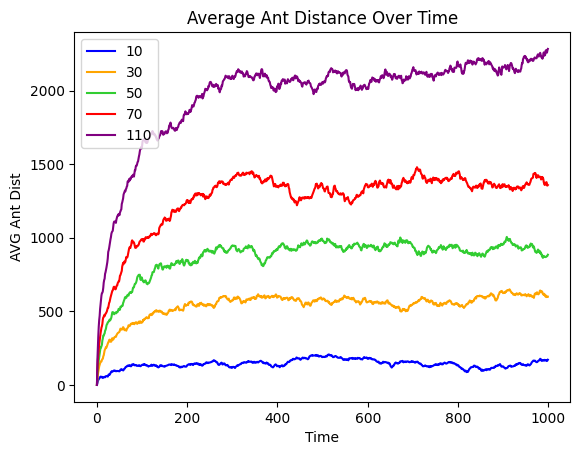

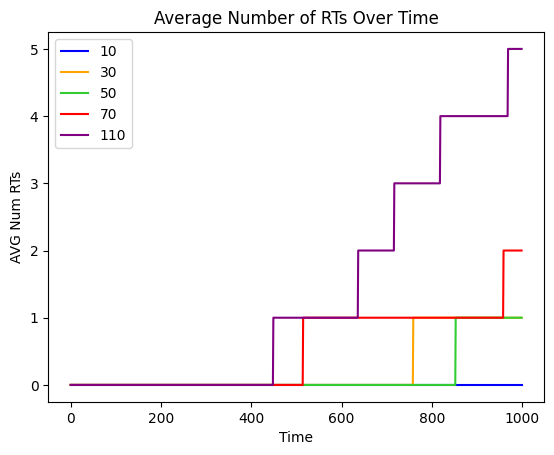

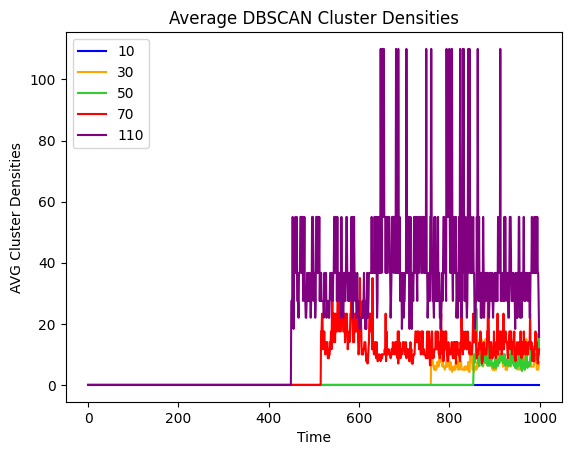

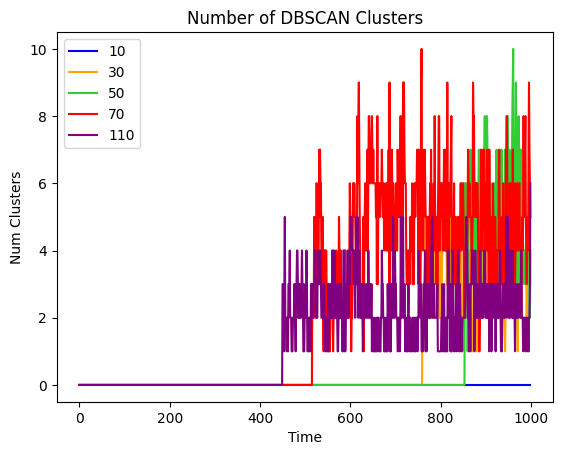

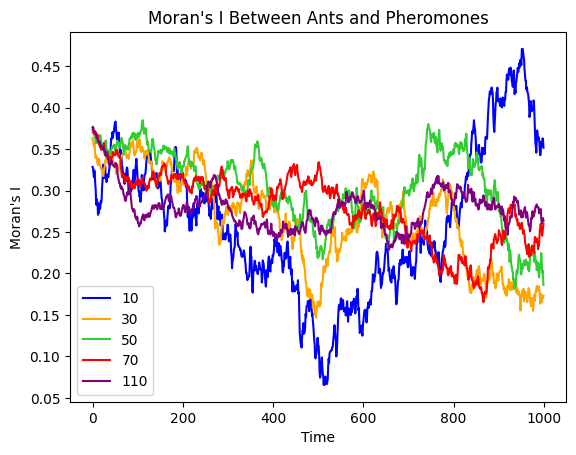

In [9]:
NAME = "main"
NUM_STEPS = 1000
ANT_POPS = [10, 30, 50, 70, 110]
ANT_POPS_COLOURS = ["blue", "orange", "limegreen", "red", "purple"]
ANT_POP_DISTS = []
AVG_NUM_RT_PER_POP_SIZE_PER_TIME = []
MORAN_IS = []
CLUSTER_DENSITIES = []
NUMBER_CLUSTERS = []
DECAY_FACTORS = [1.0]

NUM_SIMS = len(ANT_POPS)

run_ctr = 0

# standard prior
PRIOR_TICK = 1
C = np.zeros((cf.NUM_OBSERVATIONS, 1))
prior = 0
for o in range(cf.NUM_OBSERVATIONS):
    C[o] = prior
    prior += PRIOR_TICK

if __name__ == "__main__":

    for i in range(NUM_SIMS):

        num_round_trips, paths, coeff, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values = main(
            decay_factor=DECAY_FACTORS[0],
            num_steps=NUM_STEPS,
            init_ants=ANT_POPS[i],
            max_ants=ANT_POPS[i],
            C=C,
            save=True,
            switch=True,
            name=NAME,
            ant_only_gif=False,
            num_runs = NUM_SIMS,
            ctr = run_ctr
        )

        ANT_POP_DISTS.append(distances)
        CLUSTER_DENSITIES.append(cluster_densities)
        NUMBER_CLUSTERS.append(num_clusters)
        AVG_NUM_RT_PER_POP_SIZE_PER_TIME.append(num_round_trips_per_time)
        MORAN_IS.append(Morans_i_values)

        run_ctr += 1

    plt.title("Average Ant Distance Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Ant Dist")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            ANT_POP_DISTS[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average Number of RTs Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Num RTs")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            AVG_NUM_RT_PER_POP_SIZE_PER_TIME[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average DBSCAN Cluster Densities")
    plt.xlabel("Time")
    plt.ylabel("AVG Cluster Densities")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            CLUSTER_DENSITIES[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Number of DBSCAN Clusters")
    plt.xlabel("Time")
    plt.ylabel("Num Clusters")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            NUMBER_CLUSTERS[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Moran's I Between Ants and Pheromones")
    plt.xlabel("Time")
    plt.ylabel("Moran's I")
    for i in range(len(ANT_POPS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            MORAN_IS[i], 
            label=f'{ANT_POPS[i]}',
            color = ANT_POPS_COLOURS[i]
        )
    plt.legend()
    plt.show()

Step 1/1000 of Simulation 1/5
Step 2/1000 of Simulation 1/5
Step 3/1000 of Simulation 1/5
Step 4/1000 of Simulation 1/5
Step 5/1000 of Simulation 1/5
Step 6/1000 of Simulation 1/5
Step 7/1000 of Simulation 1/5
Step 8/1000 of Simulation 1/5
Step 9/1000 of Simulation 1/5
Step 10/1000 of Simulation 1/5
Step 11/1000 of Simulation 1/5
Step 12/1000 of Simulation 1/5
Step 13/1000 of Simulation 1/5
Step 14/1000 of Simulation 1/5
Step 15/1000 of Simulation 1/5
Step 16/1000 of Simulation 1/5
Step 17/1000 of Simulation 1/5
Step 18/1000 of Simulation 1/5
Step 19/1000 of Simulation 1/5
Step 20/1000 of Simulation 1/5
Step 21/1000 of Simulation 1/5
Step 22/1000 of Simulation 1/5
Step 23/1000 of Simulation 1/5
Step 24/1000 of Simulation 1/5
Step 25/1000 of Simulation 1/5
Step 26/1000 of Simulation 1/5
Step 27/1000 of Simulation 1/5
Step 28/1000 of Simulation 1/5
Step 29/1000 of Simulation 1/5
Step 30/1000 of Simulation 1/5
Step 31/1000 of Simulation 1/5
Step 32/1000 of Simulation 1/5
Step 33/1000 of S

Step 261/1000 of Simulation 1/5
Step 262/1000 of Simulation 1/5
Step 263/1000 of Simulation 1/5
Step 264/1000 of Simulation 1/5
Step 265/1000 of Simulation 1/5
Step 266/1000 of Simulation 1/5
Step 267/1000 of Simulation 1/5
Step 268/1000 of Simulation 1/5
Step 269/1000 of Simulation 1/5
Step 270/1000 of Simulation 1/5
Step 271/1000 of Simulation 1/5
Step 272/1000 of Simulation 1/5
Step 273/1000 of Simulation 1/5
Step 274/1000 of Simulation 1/5
Step 275/1000 of Simulation 1/5
Step 276/1000 of Simulation 1/5
Step 277/1000 of Simulation 1/5
Step 278/1000 of Simulation 1/5
Step 279/1000 of Simulation 1/5
Step 280/1000 of Simulation 1/5
Step 281/1000 of Simulation 1/5
Step 282/1000 of Simulation 1/5
Step 283/1000 of Simulation 1/5
Step 284/1000 of Simulation 1/5
Step 285/1000 of Simulation 1/5
Step 286/1000 of Simulation 1/5
Step 287/1000 of Simulation 1/5
Step 288/1000 of Simulation 1/5
Step 289/1000 of Simulation 1/5
Step 290/1000 of Simulation 1/5
Step 291/1000 of Simulation 1/5
Step 292

Step 518/1000 of Simulation 1/5
Step 519/1000 of Simulation 1/5
Step 520/1000 of Simulation 1/5
Step 521/1000 of Simulation 1/5
Step 522/1000 of Simulation 1/5
Step 523/1000 of Simulation 1/5
Step 524/1000 of Simulation 1/5
Step 525/1000 of Simulation 1/5
Step 526/1000 of Simulation 1/5
Step 527/1000 of Simulation 1/5
Step 528/1000 of Simulation 1/5
Step 529/1000 of Simulation 1/5
Step 530/1000 of Simulation 1/5
Step 531/1000 of Simulation 1/5
Step 532/1000 of Simulation 1/5
Step 533/1000 of Simulation 1/5
Step 534/1000 of Simulation 1/5
Step 535/1000 of Simulation 1/5
Step 536/1000 of Simulation 1/5
Step 537/1000 of Simulation 1/5
Step 538/1000 of Simulation 1/5
Step 539/1000 of Simulation 1/5
Step 540/1000 of Simulation 1/5
Step 541/1000 of Simulation 1/5
Step 542/1000 of Simulation 1/5
Step 543/1000 of Simulation 1/5
Step 544/1000 of Simulation 1/5
Step 545/1000 of Simulation 1/5
Step 546/1000 of Simulation 1/5
Step 547/1000 of Simulation 1/5
Step 548/1000 of Simulation 1/5
Step 549

Step 775/1000 of Simulation 1/5
Step 776/1000 of Simulation 1/5
Step 777/1000 of Simulation 1/5
Step 778/1000 of Simulation 1/5
Step 779/1000 of Simulation 1/5
Step 780/1000 of Simulation 1/5
Step 781/1000 of Simulation 1/5
Step 782/1000 of Simulation 1/5
Step 783/1000 of Simulation 1/5
Step 784/1000 of Simulation 1/5
Step 785/1000 of Simulation 1/5
Step 786/1000 of Simulation 1/5
Step 787/1000 of Simulation 1/5
Step 788/1000 of Simulation 1/5
Step 789/1000 of Simulation 1/5
Step 790/1000 of Simulation 1/5
Step 791/1000 of Simulation 1/5
Step 792/1000 of Simulation 1/5
Step 793/1000 of Simulation 1/5
Step 794/1000 of Simulation 1/5
Step 795/1000 of Simulation 1/5
Step 796/1000 of Simulation 1/5
Step 797/1000 of Simulation 1/5
Step 798/1000 of Simulation 1/5
Step 799/1000 of Simulation 1/5
Step 800/1000 of Simulation 1/5
Step 801/1000 of Simulation 1/5
Step 802/1000 of Simulation 1/5
Step 803/1000 of Simulation 1/5
Step 804/1000 of Simulation 1/5
Step 805/1000 of Simulation 1/5
Step 806

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 1/1000 of Simulation 2/5
Step 2/1000 of Simulation 2/5
Step 3/1000 of Simulation 2/5
Step 4/1000 of Simulation 2/5
Step 5/1000 of Simulation 2/5
Step 6/1000 of Simulation 2/5
Step 7/1000 of Simulation 2/5
Step 8/1000 of Simulation 2/5
Step 9/1000 of Simulation 2/5
Step 10/1000 of Simulation 2/5
Step 11/1000 of Simulation 2/5
Step 12/1000 of Simulation 2/5
Step 13/1000 of Simulation 2/5
Step 14/1000 of Simulation 2/5
Step 15/1000 of Simulation 2/5
Step 16/1000 of Simulation 2/5
Step 17/1000 of Simulation 2/5
Step 18/1000 of Simulation 2/5
Step 19/1000 of Simulation 2/5
Step 20/1000 of Simulation 2/5
Step 21/1000 of Simulation 2/5
Step 22/1000 of Simulation 2/5
Step 23/1000 of Simulation 2/5
Step 24/1000 of Simulation 2/5
Step 25/1000 of Simulation 2/5
Step 26/1000 of Simulation 2/5
Step 27/1000 of Simulation 2/5
Step 28/1000 of Simulation 2/5
Step 29/1000 of Simulation 2/5
Step 30/1000 of Simulation 2/5
Step 31/1000 of Simulation 2/5
Step 32/1000 of Simulation 2/5
Step 33/1000 of S

Step 261/1000 of Simulation 2/5
Step 262/1000 of Simulation 2/5
Step 263/1000 of Simulation 2/5
Step 264/1000 of Simulation 2/5
Step 265/1000 of Simulation 2/5
Step 266/1000 of Simulation 2/5
Step 267/1000 of Simulation 2/5
Step 268/1000 of Simulation 2/5
Step 269/1000 of Simulation 2/5
Step 270/1000 of Simulation 2/5
Step 271/1000 of Simulation 2/5
Step 272/1000 of Simulation 2/5
Step 273/1000 of Simulation 2/5
Step 274/1000 of Simulation 2/5
Step 275/1000 of Simulation 2/5
Step 276/1000 of Simulation 2/5
Step 277/1000 of Simulation 2/5
Step 278/1000 of Simulation 2/5
Step 279/1000 of Simulation 2/5
Step 280/1000 of Simulation 2/5
Step 281/1000 of Simulation 2/5
Step 282/1000 of Simulation 2/5
Step 283/1000 of Simulation 2/5
Step 284/1000 of Simulation 2/5
Step 285/1000 of Simulation 2/5
Step 286/1000 of Simulation 2/5
Step 287/1000 of Simulation 2/5
Step 288/1000 of Simulation 2/5
Step 289/1000 of Simulation 2/5
Step 290/1000 of Simulation 2/5
Step 291/1000 of Simulation 2/5
Step 292

Step 518/1000 of Simulation 2/5
Step 519/1000 of Simulation 2/5
Step 520/1000 of Simulation 2/5
Step 521/1000 of Simulation 2/5
Step 522/1000 of Simulation 2/5
Step 523/1000 of Simulation 2/5
Step 524/1000 of Simulation 2/5
Step 525/1000 of Simulation 2/5
Step 526/1000 of Simulation 2/5
Step 527/1000 of Simulation 2/5
Step 528/1000 of Simulation 2/5
Step 529/1000 of Simulation 2/5
Step 530/1000 of Simulation 2/5
Step 531/1000 of Simulation 2/5
Step 532/1000 of Simulation 2/5
Step 533/1000 of Simulation 2/5
Step 534/1000 of Simulation 2/5
Step 535/1000 of Simulation 2/5
Step 536/1000 of Simulation 2/5
Step 537/1000 of Simulation 2/5
Step 538/1000 of Simulation 2/5
Step 539/1000 of Simulation 2/5
Step 540/1000 of Simulation 2/5
Step 541/1000 of Simulation 2/5
Step 542/1000 of Simulation 2/5
Step 543/1000 of Simulation 2/5
Step 544/1000 of Simulation 2/5
Step 545/1000 of Simulation 2/5
Step 546/1000 of Simulation 2/5
Step 547/1000 of Simulation 2/5
Step 548/1000 of Simulation 2/5
Step 549

Step 775/1000 of Simulation 2/5
Step 776/1000 of Simulation 2/5
Step 777/1000 of Simulation 2/5
Step 778/1000 of Simulation 2/5
Step 779/1000 of Simulation 2/5
Step 780/1000 of Simulation 2/5
Step 781/1000 of Simulation 2/5
Step 782/1000 of Simulation 2/5
Step 783/1000 of Simulation 2/5
Step 784/1000 of Simulation 2/5
Step 785/1000 of Simulation 2/5
Step 786/1000 of Simulation 2/5
Step 787/1000 of Simulation 2/5
Step 788/1000 of Simulation 2/5
Step 789/1000 of Simulation 2/5
Step 790/1000 of Simulation 2/5
Step 791/1000 of Simulation 2/5
Step 792/1000 of Simulation 2/5
Step 793/1000 of Simulation 2/5
Step 794/1000 of Simulation 2/5
Step 795/1000 of Simulation 2/5
Step 796/1000 of Simulation 2/5
Step 797/1000 of Simulation 2/5
Step 798/1000 of Simulation 2/5
Step 799/1000 of Simulation 2/5
Step 800/1000 of Simulation 2/5
Step 801/1000 of Simulation 2/5
Step 802/1000 of Simulation 2/5
Step 803/1000 of Simulation 2/5
Step 804/1000 of Simulation 2/5
Step 805/1000 of Simulation 2/5
Step 806

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 1/1000 of Simulation 3/5
Step 2/1000 of Simulation 3/5
Step 3/1000 of Simulation 3/5
Step 4/1000 of Simulation 3/5
Step 5/1000 of Simulation 3/5
Step 6/1000 of Simulation 3/5
Step 7/1000 of Simulation 3/5
Step 8/1000 of Simulation 3/5
Step 9/1000 of Simulation 3/5
Step 10/1000 of Simulation 3/5
Step 11/1000 of Simulation 3/5
Step 12/1000 of Simulation 3/5
Step 13/1000 of Simulation 3/5
Step 14/1000 of Simulation 3/5
Step 15/1000 of Simulation 3/5
Step 16/1000 of Simulation 3/5
Step 17/1000 of Simulation 3/5
Step 18/1000 of Simulation 3/5
Step 19/1000 of Simulation 3/5
Step 20/1000 of Simulation 3/5
Step 21/1000 of Simulation 3/5
Step 22/1000 of Simulation 3/5
Step 23/1000 of Simulation 3/5
Step 24/1000 of Simulation 3/5
Step 25/1000 of Simulation 3/5
Step 26/1000 of Simulation 3/5
Step 27/1000 of Simulation 3/5
Step 28/1000 of Simulation 3/5
Step 29/1000 of Simulation 3/5
Step 30/1000 of Simulation 3/5
Step 31/1000 of Simulation 3/5
Step 32/1000 of Simulation 3/5
Step 33/1000 of S

Step 262/1000 of Simulation 3/5
Step 263/1000 of Simulation 3/5
Step 264/1000 of Simulation 3/5
Step 265/1000 of Simulation 3/5
Step 266/1000 of Simulation 3/5
Step 267/1000 of Simulation 3/5
Step 268/1000 of Simulation 3/5
Step 269/1000 of Simulation 3/5
Step 270/1000 of Simulation 3/5
Step 271/1000 of Simulation 3/5
Step 272/1000 of Simulation 3/5
Step 273/1000 of Simulation 3/5
Step 274/1000 of Simulation 3/5
Step 275/1000 of Simulation 3/5
Step 276/1000 of Simulation 3/5
Step 277/1000 of Simulation 3/5
Step 278/1000 of Simulation 3/5
Step 279/1000 of Simulation 3/5
Step 280/1000 of Simulation 3/5
Step 281/1000 of Simulation 3/5
Step 282/1000 of Simulation 3/5
Step 283/1000 of Simulation 3/5
Step 284/1000 of Simulation 3/5
Step 285/1000 of Simulation 3/5
Step 286/1000 of Simulation 3/5
Step 287/1000 of Simulation 3/5
Step 288/1000 of Simulation 3/5
Step 289/1000 of Simulation 3/5
Step 290/1000 of Simulation 3/5
Step 291/1000 of Simulation 3/5
Step 292/1000 of Simulation 3/5
Step 293

Step 519/1000 of Simulation 3/5
Step 520/1000 of Simulation 3/5
Step 521/1000 of Simulation 3/5
Step 522/1000 of Simulation 3/5
Step 523/1000 of Simulation 3/5
Step 524/1000 of Simulation 3/5
Step 525/1000 of Simulation 3/5
Step 526/1000 of Simulation 3/5
Step 527/1000 of Simulation 3/5
Step 528/1000 of Simulation 3/5
Step 529/1000 of Simulation 3/5
Step 530/1000 of Simulation 3/5
Step 531/1000 of Simulation 3/5
Step 532/1000 of Simulation 3/5
Step 533/1000 of Simulation 3/5
Step 534/1000 of Simulation 3/5
Step 535/1000 of Simulation 3/5
Step 536/1000 of Simulation 3/5
Step 537/1000 of Simulation 3/5
Step 538/1000 of Simulation 3/5
Step 539/1000 of Simulation 3/5
Step 540/1000 of Simulation 3/5
Step 541/1000 of Simulation 3/5
Step 542/1000 of Simulation 3/5
Step 543/1000 of Simulation 3/5
Step 544/1000 of Simulation 3/5
Step 545/1000 of Simulation 3/5
Step 546/1000 of Simulation 3/5
Step 547/1000 of Simulation 3/5
Step 548/1000 of Simulation 3/5
Step 549/1000 of Simulation 3/5
Step 550

Step 776/1000 of Simulation 3/5
Step 777/1000 of Simulation 3/5
Step 778/1000 of Simulation 3/5
Step 779/1000 of Simulation 3/5
Step 780/1000 of Simulation 3/5
Step 781/1000 of Simulation 3/5
Step 782/1000 of Simulation 3/5
Step 783/1000 of Simulation 3/5
Step 784/1000 of Simulation 3/5
Step 785/1000 of Simulation 3/5
Step 786/1000 of Simulation 3/5
Step 787/1000 of Simulation 3/5
Step 788/1000 of Simulation 3/5
Step 789/1000 of Simulation 3/5
Step 790/1000 of Simulation 3/5
Step 791/1000 of Simulation 3/5
Step 792/1000 of Simulation 3/5
Step 793/1000 of Simulation 3/5
Step 794/1000 of Simulation 3/5
Step 795/1000 of Simulation 3/5
Step 796/1000 of Simulation 3/5
Step 797/1000 of Simulation 3/5
Step 798/1000 of Simulation 3/5
Step 799/1000 of Simulation 3/5
Step 800/1000 of Simulation 3/5
Step 801/1000 of Simulation 3/5
Step 802/1000 of Simulation 3/5
Step 803/1000 of Simulation 3/5
Step 804/1000 of Simulation 3/5
Step 805/1000 of Simulation 3/5
Step 806/1000 of Simulation 3/5
Step 807

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 1/1000 of Simulation 4/5
Step 2/1000 of Simulation 4/5
Step 3/1000 of Simulation 4/5
Step 4/1000 of Simulation 4/5
Step 5/1000 of Simulation 4/5
Step 6/1000 of Simulation 4/5
Step 7/1000 of Simulation 4/5
Step 8/1000 of Simulation 4/5
Step 9/1000 of Simulation 4/5
Step 10/1000 of Simulation 4/5
Step 11/1000 of Simulation 4/5
Step 12/1000 of Simulation 4/5
Step 13/1000 of Simulation 4/5
Step 14/1000 of Simulation 4/5
Step 15/1000 of Simulation 4/5
Step 16/1000 of Simulation 4/5
Step 17/1000 of Simulation 4/5
Step 18/1000 of Simulation 4/5
Step 19/1000 of Simulation 4/5
Step 20/1000 of Simulation 4/5
Step 21/1000 of Simulation 4/5
Step 22/1000 of Simulation 4/5
Step 23/1000 of Simulation 4/5
Step 24/1000 of Simulation 4/5
Step 25/1000 of Simulation 4/5
Step 26/1000 of Simulation 4/5
Step 27/1000 of Simulation 4/5
Step 28/1000 of Simulation 4/5
Step 29/1000 of Simulation 4/5
Step 30/1000 of Simulation 4/5
Step 31/1000 of Simulation 4/5
Step 32/1000 of Simulation 4/5
Step 33/1000 of S

Step 261/1000 of Simulation 4/5
Step 262/1000 of Simulation 4/5
Step 263/1000 of Simulation 4/5
Step 264/1000 of Simulation 4/5
Step 265/1000 of Simulation 4/5
Step 266/1000 of Simulation 4/5
Step 267/1000 of Simulation 4/5
Step 268/1000 of Simulation 4/5
Step 269/1000 of Simulation 4/5
Step 270/1000 of Simulation 4/5
Step 271/1000 of Simulation 4/5
Step 272/1000 of Simulation 4/5
Step 273/1000 of Simulation 4/5
Step 274/1000 of Simulation 4/5
Step 275/1000 of Simulation 4/5
Step 276/1000 of Simulation 4/5
Step 277/1000 of Simulation 4/5
Step 278/1000 of Simulation 4/5
Step 279/1000 of Simulation 4/5
Step 280/1000 of Simulation 4/5
Step 281/1000 of Simulation 4/5
Step 282/1000 of Simulation 4/5
Step 283/1000 of Simulation 4/5
Step 284/1000 of Simulation 4/5
Step 285/1000 of Simulation 4/5
Step 286/1000 of Simulation 4/5
Step 287/1000 of Simulation 4/5
Step 288/1000 of Simulation 4/5
Step 289/1000 of Simulation 4/5
Step 290/1000 of Simulation 4/5
Step 291/1000 of Simulation 4/5
Step 292

Step 519/1000 of Simulation 4/5
Step 520/1000 of Simulation 4/5
Step 521/1000 of Simulation 4/5
Step 522/1000 of Simulation 4/5
Step 523/1000 of Simulation 4/5
Step 524/1000 of Simulation 4/5
Step 525/1000 of Simulation 4/5
Step 526/1000 of Simulation 4/5
Step 527/1000 of Simulation 4/5
Step 528/1000 of Simulation 4/5
Step 529/1000 of Simulation 4/5
Step 530/1000 of Simulation 4/5
Step 531/1000 of Simulation 4/5
Step 532/1000 of Simulation 4/5
Step 533/1000 of Simulation 4/5
Step 534/1000 of Simulation 4/5
Step 535/1000 of Simulation 4/5
Step 536/1000 of Simulation 4/5
Step 537/1000 of Simulation 4/5
Step 538/1000 of Simulation 4/5
Step 539/1000 of Simulation 4/5
Step 540/1000 of Simulation 4/5
Step 541/1000 of Simulation 4/5
Step 542/1000 of Simulation 4/5
Step 543/1000 of Simulation 4/5
Step 544/1000 of Simulation 4/5
Step 545/1000 of Simulation 4/5
Step 546/1000 of Simulation 4/5
Step 547/1000 of Simulation 4/5
Step 548/1000 of Simulation 4/5
Step 549/1000 of Simulation 4/5
Step 550

Step 777/1000 of Simulation 4/5
Step 778/1000 of Simulation 4/5
Step 779/1000 of Simulation 4/5
Step 780/1000 of Simulation 4/5
Step 781/1000 of Simulation 4/5
Step 782/1000 of Simulation 4/5
Step 783/1000 of Simulation 4/5
Step 784/1000 of Simulation 4/5
Step 785/1000 of Simulation 4/5
Step 786/1000 of Simulation 4/5
Step 787/1000 of Simulation 4/5
Step 788/1000 of Simulation 4/5
Step 789/1000 of Simulation 4/5
Step 790/1000 of Simulation 4/5
Step 791/1000 of Simulation 4/5
Step 792/1000 of Simulation 4/5
Step 793/1000 of Simulation 4/5
Step 794/1000 of Simulation 4/5
Step 795/1000 of Simulation 4/5
Step 796/1000 of Simulation 4/5
Step 797/1000 of Simulation 4/5
Step 798/1000 of Simulation 4/5
Step 799/1000 of Simulation 4/5
Step 800/1000 of Simulation 4/5
Step 801/1000 of Simulation 4/5
Step 802/1000 of Simulation 4/5
Step 803/1000 of Simulation 4/5
Step 804/1000 of Simulation 4/5
Step 805/1000 of Simulation 4/5
Step 806/1000 of Simulation 4/5
Step 807/1000 of Simulation 4/5
Step 808

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


Step 1/1000 of Simulation 5/5
Step 2/1000 of Simulation 5/5
Step 3/1000 of Simulation 5/5
Step 4/1000 of Simulation 5/5
Step 5/1000 of Simulation 5/5
Step 6/1000 of Simulation 5/5
Step 7/1000 of Simulation 5/5
Step 8/1000 of Simulation 5/5
Step 9/1000 of Simulation 5/5
Step 10/1000 of Simulation 5/5
Step 11/1000 of Simulation 5/5
Step 12/1000 of Simulation 5/5
Step 13/1000 of Simulation 5/5
Step 14/1000 of Simulation 5/5
Step 15/1000 of Simulation 5/5
Step 16/1000 of Simulation 5/5
Step 17/1000 of Simulation 5/5
Step 18/1000 of Simulation 5/5
Step 19/1000 of Simulation 5/5
Step 20/1000 of Simulation 5/5
Step 21/1000 of Simulation 5/5
Step 22/1000 of Simulation 5/5
Step 23/1000 of Simulation 5/5
Step 24/1000 of Simulation 5/5
Step 25/1000 of Simulation 5/5
Step 26/1000 of Simulation 5/5
Step 27/1000 of Simulation 5/5
Step 28/1000 of Simulation 5/5
Step 29/1000 of Simulation 5/5
Step 30/1000 of Simulation 5/5
Step 31/1000 of Simulation 5/5
Step 32/1000 of Simulation 5/5
Step 33/1000 of S

Step 262/1000 of Simulation 5/5
Step 263/1000 of Simulation 5/5
Step 264/1000 of Simulation 5/5
Step 265/1000 of Simulation 5/5
Step 266/1000 of Simulation 5/5
Step 267/1000 of Simulation 5/5
Step 268/1000 of Simulation 5/5
Step 269/1000 of Simulation 5/5
Step 270/1000 of Simulation 5/5
Step 271/1000 of Simulation 5/5
Step 272/1000 of Simulation 5/5
Step 273/1000 of Simulation 5/5
Step 274/1000 of Simulation 5/5
Step 275/1000 of Simulation 5/5
Step 276/1000 of Simulation 5/5
Step 277/1000 of Simulation 5/5
Step 278/1000 of Simulation 5/5
Step 279/1000 of Simulation 5/5
Step 280/1000 of Simulation 5/5
Step 281/1000 of Simulation 5/5
Step 282/1000 of Simulation 5/5
Step 283/1000 of Simulation 5/5
Step 284/1000 of Simulation 5/5
Step 285/1000 of Simulation 5/5
Step 286/1000 of Simulation 5/5
Step 287/1000 of Simulation 5/5
Step 288/1000 of Simulation 5/5
Step 289/1000 of Simulation 5/5
Step 290/1000 of Simulation 5/5
Step 291/1000 of Simulation 5/5
Step 292/1000 of Simulation 5/5
Step 293

Step 520/1000 of Simulation 5/5
Step 521/1000 of Simulation 5/5
Step 522/1000 of Simulation 5/5
Step 523/1000 of Simulation 5/5
Step 524/1000 of Simulation 5/5
Step 525/1000 of Simulation 5/5
Step 526/1000 of Simulation 5/5
Step 527/1000 of Simulation 5/5
Step 528/1000 of Simulation 5/5
Step 529/1000 of Simulation 5/5
Step 530/1000 of Simulation 5/5
Step 531/1000 of Simulation 5/5
Step 532/1000 of Simulation 5/5
Step 533/1000 of Simulation 5/5
Step 534/1000 of Simulation 5/5
Step 535/1000 of Simulation 5/5
Step 536/1000 of Simulation 5/5
Step 537/1000 of Simulation 5/5
Step 538/1000 of Simulation 5/5
Step 539/1000 of Simulation 5/5
Step 540/1000 of Simulation 5/5
Step 541/1000 of Simulation 5/5
Step 542/1000 of Simulation 5/5
Step 543/1000 of Simulation 5/5
Step 544/1000 of Simulation 5/5
Step 545/1000 of Simulation 5/5
Step 546/1000 of Simulation 5/5
Step 547/1000 of Simulation 5/5
Step 548/1000 of Simulation 5/5
Step 549/1000 of Simulation 5/5
Step 550/1000 of Simulation 5/5
Step 551

Step 777/1000 of Simulation 5/5
Step 778/1000 of Simulation 5/5
Step 779/1000 of Simulation 5/5
Step 780/1000 of Simulation 5/5
Step 781/1000 of Simulation 5/5
Step 782/1000 of Simulation 5/5
Step 783/1000 of Simulation 5/5
Step 784/1000 of Simulation 5/5
Step 785/1000 of Simulation 5/5
Step 786/1000 of Simulation 5/5
Step 787/1000 of Simulation 5/5
Step 788/1000 of Simulation 5/5
Step 789/1000 of Simulation 5/5
Step 790/1000 of Simulation 5/5
Step 791/1000 of Simulation 5/5
Step 792/1000 of Simulation 5/5
Step 793/1000 of Simulation 5/5
Step 794/1000 of Simulation 5/5
Step 795/1000 of Simulation 5/5
Step 796/1000 of Simulation 5/5
Step 797/1000 of Simulation 5/5
Step 798/1000 of Simulation 5/5
Step 799/1000 of Simulation 5/5
Step 800/1000 of Simulation 5/5
Step 801/1000 of Simulation 5/5
Step 802/1000 of Simulation 5/5
Step 803/1000 of Simulation 5/5
Step 804/1000 of Simulation 5/5
Step 805/1000 of Simulation 5/5
Step 806/1000 of Simulation 5/5
Step 807/1000 of Simulation 5/5
Step 808

/tmp/ipykernel_633262/4076390199.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return completed_trips, np.array(paths), distance, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values


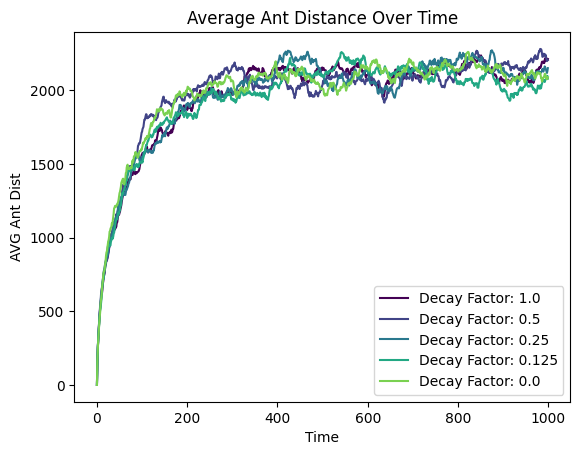

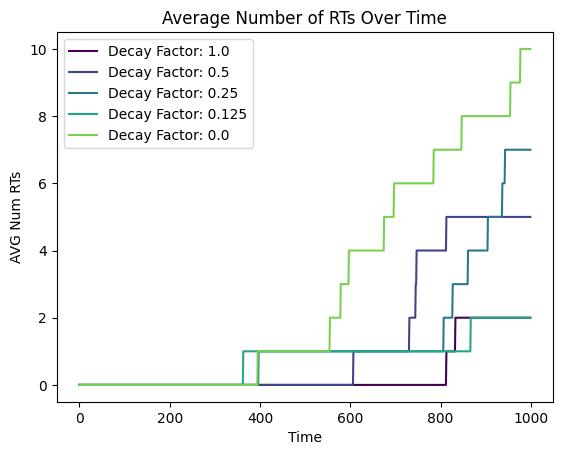

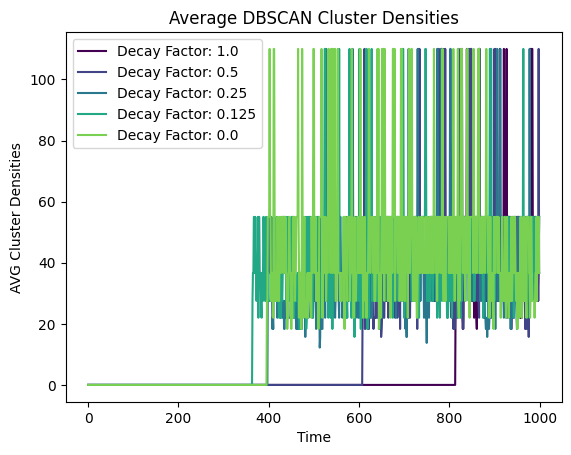

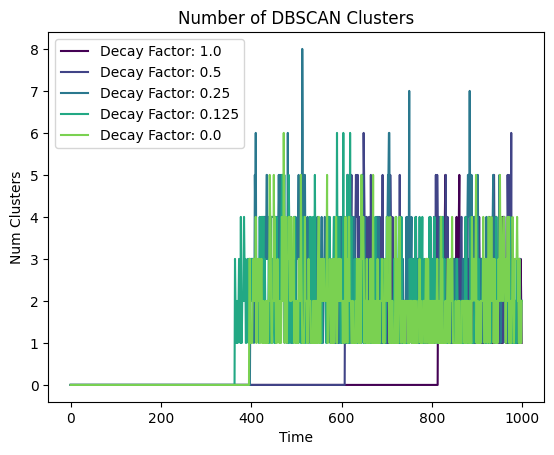

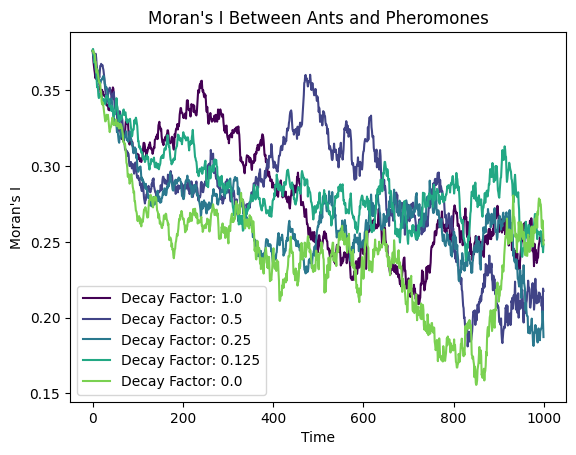

In [10]:
NAME = "main"
NUM_STEPS = 1000
ANT_POPS = [10, 30, 50, 70, 110]
# ANT_POPS_COLOURS = ["blue", "orange", "limegreen", "red", "purple"]
CMAP = plt.get_cmap("viridis")
ANT_POP_DISTS = []
AVG_NUM_RT_PER_POP_SIZE_PER_TIME = []
MORAN_IS = []
CLUSTER_DENSITIES = []
NUMBER_CLUSTERS = []
DECAY_FACTORS = [1.0, 0.5, 0.25, 0.125, 0.0]
COLOURS = [CMAP(i / len(DECAY_FACTORS)) for i in range(len(DECAY_FACTORS))]

NUM_SIMS = len(ANT_POPS)

run_ctr = 0

# standard prior
PRIOR_TICK = 1
C = np.zeros((cf.NUM_OBSERVATIONS, 1))
prior = 0
for o in range(cf.NUM_OBSERVATIONS):
    C[o] = prior
    prior += PRIOR_TICK

if __name__ == "__main__":

    for i in range(NUM_SIMS):

        num_round_trips, paths, coeff, distances, num_round_trips_per_time, ants, cluster_densities, num_clusters, Morans_i_values = main(
            decay_factor=DECAY_FACTORS[i],
            num_steps=NUM_STEPS,
            init_ants=ANT_POPS[4],
            max_ants=ANT_POPS[4],
            C=C,
            save=True,
            switch=True,
            name=NAME,
            ant_only_gif=False,
            num_runs = NUM_SIMS,
            ctr = run_ctr
        )

        ANT_POP_DISTS.append(distances)
        CLUSTER_DENSITIES.append(cluster_densities)
        NUMBER_CLUSTERS.append(num_clusters)
        AVG_NUM_RT_PER_POP_SIZE_PER_TIME.append(num_round_trips_per_time)
        MORAN_IS.append(Morans_i_values)

        run_ctr += 1

    plt.title("Average Ant Distance Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Ant Dist")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            ANT_POP_DISTS[i], 
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average Number of RTs Over Time")
    plt.xlabel("Time")
    plt.ylabel("AVG Num RTs")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            AVG_NUM_RT_PER_POP_SIZE_PER_TIME[i], 
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Average DBSCAN Cluster Densities")
    plt.xlabel("Time")
    plt.ylabel("AVG Cluster Densities")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            CLUSTER_DENSITIES[i], 
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Number of DBSCAN Clusters")
    plt.xlabel("Time")
    plt.ylabel("Num Clusters")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            NUMBER_CLUSTERS[i], 
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()

    plt.title("Moran's I Between Ants and Pheromones")
    plt.xlabel("Time")
    plt.ylabel("Moran's I")
    for i in range(len(DECAY_FACTORS)):
        plt.plot(
            [step for step in range(NUM_STEPS)], 
            MORAN_IS[i], 
            label=f'Decay Factor: {DECAY_FACTORS[i]}',
            color = COLOURS[i]
        )
    plt.legend()
    plt.show()